# Simple FEM for an elastic plate with a hole

In [1]:
from torchfem.io import import_mesh
from torchfem.materials import IsotropicPlaneStrain
import pygmsh

from global_constants import EPS0, LBD, MU, L, R

## Material model

In [2]:
E = MU * (3 * LBD + 2 * MU) / (LBD + MU)
nu = LBD / (2 * (LBD + MU))
material = IsotropicPlaneStrain(E=E, nu=nu)

## Create a mesh for the plate with hole

First we need to build the geometry. The shape and mesh is generated with pygmsh, exported to a vtk file and then imported for use in torch-fem.

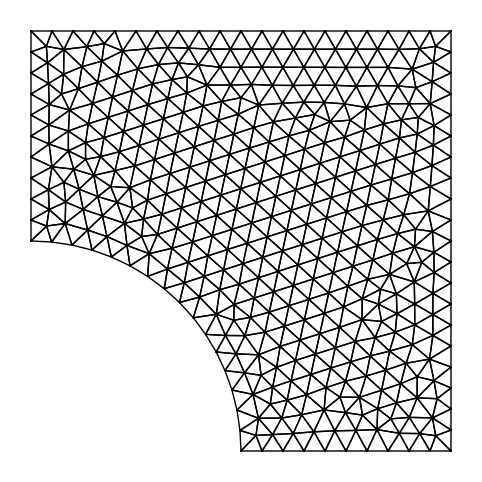

In [3]:
# Element size
N = 20
s = L / N
order = 2

# Build geometry and export mesh
with pygmsh.occ.Geometry() as geom:
    geom.characteristic_length_max = s
    rectangle = geom.add_rectangle([0.0, 0.0, 0.0], a=L, b=L)
    hole = geom.add_ellipsoid([0, 0, 0.0], [R, R, 100.0])
    geom.boolean_difference(rectangle, hole)
    m = geom.generate_mesh(order=order)
    m.write("mesh{order}.vtk")

# Convert to scikit-fem mesh
mesh = import_mesh("mesh{order}.vtk", C=material.C())

mesh.plot()

## Boundary conditions

Left: 

$$ u_1 = 0$$

Bottom: 

$$ u_2 = 0$$

Right: 

$$ u_1 = \varepsilon_0 L\\  
   u_2 =0
$$

In [4]:
# Left
left = mesh.nodes[:, 0] == 0
mesh.constraints[left, 0] = True

# Bottom
bottom = mesh.nodes[:, 1] == 0
mesh.constraints[bottom, 1] = True

# Right
right = mesh.nodes[:, 0] == L
mesh.constraints[right, 0] = True
mesh.displacements[right, 0] = EPS0

## Assemble and solve

In [5]:
u, f = mesh.solve()

## Postprocessing

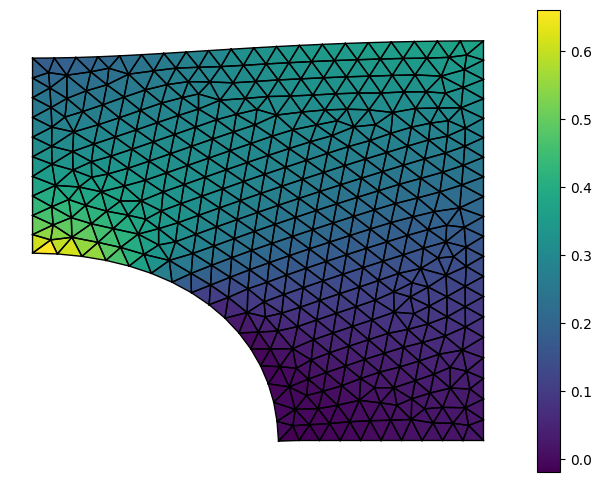

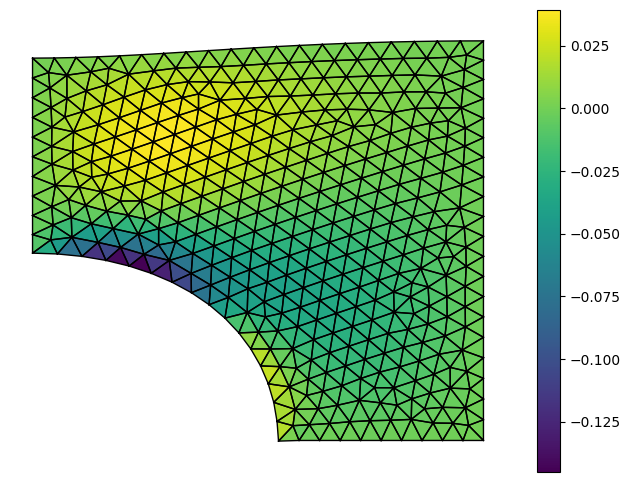

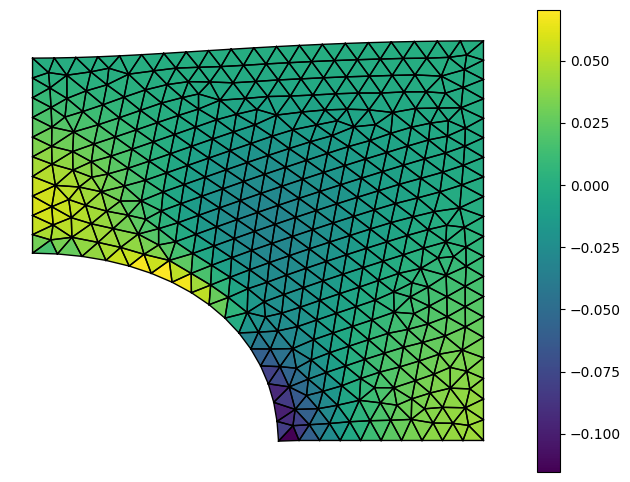

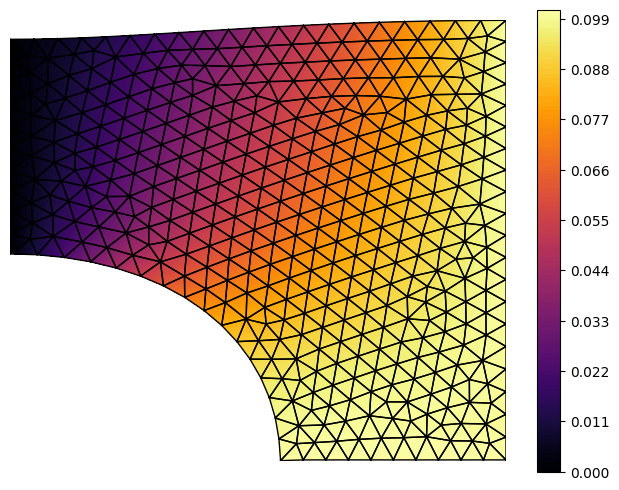

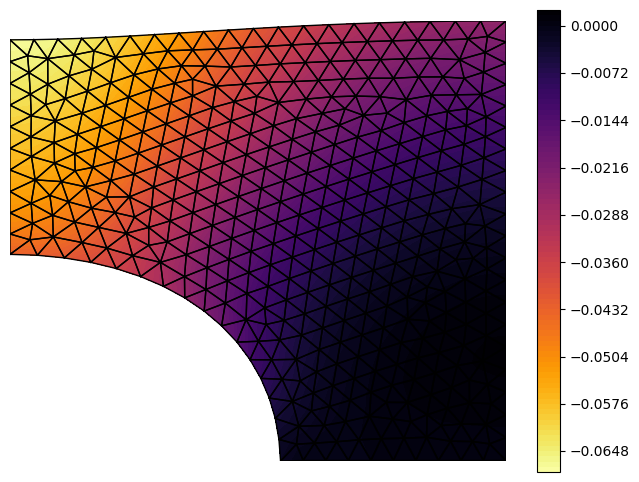

In [6]:
# Stress evaluated at the center of each element
stress = mesh.compute_stress(u, xi=[1.0 / 3.0, 1.0 / 3.0])

mesh.plot(u=u, element_property=stress[:, 0], colorbar=True, bcs=False)
mesh.plot(u=u, element_property=stress[:, 2], colorbar=True, bcs=False)
mesh.plot(u=u, element_property=stress[:, 1], colorbar=True, bcs=False)
mesh.plot(u=u, node_property=u[:, 0], cmap="inferno", colorbar=True, bcs=False)
mesh.plot(u=u, node_property=u[:, 1], cmap="inferno_r", colorbar=True, bcs=False)